In [1]:
import torchvision.transforms
import source.data
import source.utils
import torch.hub
import torch.utils.data
import torch
import torch.optim
_  = torch.manual_seed(0)

In [2]:
image_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((280, 280)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(lambda image_as_int_tensor: image_as_int_tensor / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((280, 280)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(
        lambda mask_as_int_tensor: mask_as_int_tensor.squeeze().type(torch.LongTensor)
    ),
])

dataset = source.data.PascalPartSmallDataset(
    transform=image_transform,
    target_transform=mask_transform
)

class View(torch.nn.Module):

    def __init__(self, shape: tuple[int, ...]):
        super().__init__()
        self.shape = shape

    def forward(self, input: torch.Tensor):
        return input.view(-1, *self.shape)

dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=10)

backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

head = torch.nn.Sequential(
    torch.nn.Linear(384, 1225),

    View((1, 35, 35)),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=1, out_channels=7, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.ReLU(),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.ReLU(),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(3, 3), padding=(1, 1)),
)

optimizer = torch.optim.AdamW(head.parameters())
loss_function = torch.nn.NLLLoss()

Using cache found in /Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main
/Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
metrics_tracker: dict[int, list[float]] = {index:[] for index in range(-1, 7)}
n_epochs = 10

for epoch in range(n_epochs):
    for iteration, (images, masks) in enumerate(dataloader):
        embeddings = backbone(images)
        logits = head(embeddings)

        log_probabilities = torch.nn.functional.log_softmax(
            logits,
            dim=1, # B x C x H x W
        )

        loss_value = loss_function(
            log_probabilities,
            masks
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=log_probabilities,
            masks=masks,
            classes=list(dataset.class_to_name.keys()),
        )

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        metrics_tracker[-1].append(loss_value.detach().item())
        for object_class in list(dataset.class_to_name.keys()):
            metrics_tracker[object_class].append(
                intersection_over_union_per_class[object_class].mean().item()
            )

        if iteration % 10 == 0:
            print(
                f"Iteration: {epoch * len(dataloader) + iteration}" +
                f"/ {n_epochs*len(dataloader)}"
                f"Loss value: {metrics_tracker[-1][-1]:.3f} \t ",
                "IoU - ",
                *[
                    f"{dataset.class_to_name[object_class]} : " +
                    f"{metrics_tracker[object_class][-1]:.3f} \t "
                    for object_class in list(dataset.class_to_name.keys())
                ]
            )

Epoch:0 	 Iteration: 1 / 100 	 Loss value: 1.932 	  IoU -  bg : 0.039 	  low_hand : 0.074 	  torso : 0.610 	  low_leg : 0.013 	  head : 0.009 	  up_leg : 0.015 	  up_hand : 0.061 	 
Epoch:0 	 Iteration: 2 / 100 	 Loss value: 1.927 	  IoU -  bg : 0.089 	  low_hand : 0.056 	  torso : 0.530 	  low_leg : 0.008 	  head : 0.016 	  up_leg : 0.012 	  up_hand : 0.029 	 
Epoch:0 	 Iteration: 3 / 100 	 Loss value: 1.907 	  IoU -  bg : 0.167 	  low_hand : 0.069 	  torso : 0.567 	  low_leg : 0.008 	  head : 0.022 	  up_leg : 0.018 	  up_hand : 0.010 	 
Epoch:0 	 Iteration: 4 / 100 	 Loss value: 1.914 	  IoU -  bg : 0.239 	  low_hand : 0.073 	  torso : 0.420 	  low_leg : 0.016 	  head : 0.027 	  up_leg : 0.012 	  up_hand : 0.014 	 
Epoch:0 	 Iteration: 6 / 100 	 Loss value: 1.899 	  IoU -  bg : 0.400 	  low_hand : 0.166 	  torso : 0.343 	  low_leg : 0.014 	  head : 0.052 	  up_leg : 0.002 	  up_hand : 0.017 	 
Epoch:0 	 Iteration: 7 / 100 	 Loss value: 1.878 	  IoU -  bg : 0.491 	  low_hand : 0.235 

KeyboardInterrupt: 

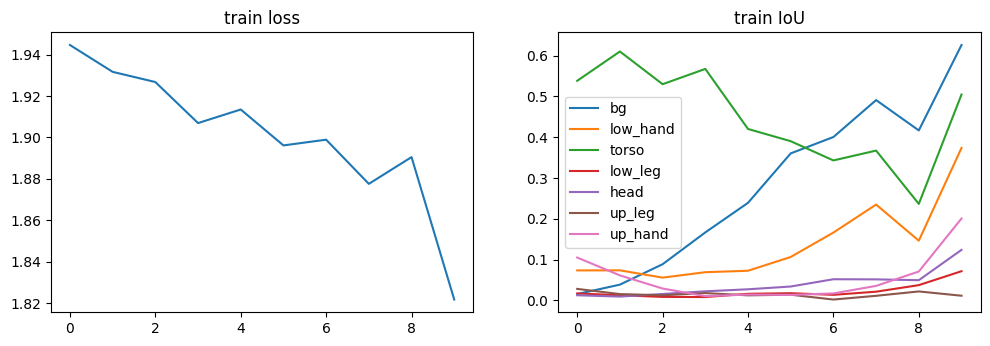

In [4]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(12, 8))

figure.add_subplot(2, 2, 1)
plt.plot(metrics_tracker[-1], label="")
plt.title("train loss")

figure.add_subplot(2, 2, 2)
[
    plt.plot(metrics_tracker[index], label=dataset.class_to_name[index])
    for index in range(0, 7)
]
plt.legend()
plt.title("train IoU")

plt.show()